# Generic

## Llibreries

In [1]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import random

In [2]:
import nltk
nltk. download('movie_reviews')
from nltk.corpus import movie_reviews as mr

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\llumf\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


## Obtenció de dades i divisió train-test

### Ids
per tema optimitzacio de carga trectarem amb ids

In [3]:
def obtenir_ids(x): # x és l'etiqueta pos o neg per obtenir les dades dels documents d'opinió positiva i negativa
    lst = []
    for i in mr.fileids(x):
        lst.append(i)
    return(lst)

In [4]:
id_neg = obtenir_ids("neg")
id_pos = obtenir_ids("pos")

### Dividir

In [5]:
def dividir(dad,semilla):
    random.seed(semilla)
    split_index = int(len(dad) * 0.2)
    shuffled = random.sample(dad, len(dad))
    train = shuffled[split_index:]
    test = shuffled[:split_index]
    return train, test

In [6]:
train_neg_id, test_neg_id = dividir(id_neg,21)
train_pos_id, test_pos_id = dividir(id_pos,32)

### Paraules

In [7]:
def obtenir_paraules(ids): # x és l'etiqueta pos o neg per obtenir les dades dels documents d'opinió positiva i negativa
    lst = []
    for i in ids:
        lst.append(mr.words(i))
    return(lst)

In [8]:
train_neg = obtenir_paraules(train_neg_id)
test_neg = obtenir_paraules(test_neg_id)
train_pos = obtenir_paraules(train_pos_id)
test_pos = obtenir_paraules(test_pos_id)

# Part A

## Preprocesing

### Caràcters

#### Basic

In [9]:
import re

In [10]:
def nomes_lletres_nbsp(text):
    lst = []
    for i in range(len(text)):
        lst.append([])
        for j in range(len(text[i])):
            x = re.sub('[^a-zA-Z]|nbsp', '', text[i][j]) 
            # no es mantenen lletre amb accents perquè en anglès no n'hi ha. Si canviessim l'idioma hauríem d'afegir caràcters a mantenir
            if x != '':
                lst[i].append(x)
    return lst

In [11]:
def prepro1(dades):
    return nomes_lletres_nbsp(dades)

In [12]:
train_neg_a = prepro1(train_neg)
test_neg_a = prepro1(test_neg)
train_pos_a = prepro1(train_pos)
test_pos_a = prepro1(test_pos)

#### Apòstrof

In [13]:
def grup_apostrofs(words):
    new_words = []
    for w in words:
        new_w = []
        j = 0
        while j < len(w):
            if w[j] == "'":
                if j == 0:
                    new_w.append(w[j] + w[j+1])
                    j += 2
                elif j == len(w)-1:
                    new_w[-1] += w[j]
                    j += 1
                else:
                    new_w[-1] += w[j] + w[j+1]
                    j += 2
            else:
                new_w.append(w[j])
                j += 1
        new_words.append(new_w)
    return new_words


In [14]:
def nomes_lletres_nbsp_apostrof(text):
    lst = []
    for i in range(len(text)):
        lst.append([])
        for j in range(len(text[i])):
            x = re.sub("[^a-zA-Z']|nbsp", '', text[i][j])
            if x != '':
                lst[i].append(x)
    return lst


In [15]:
def prepro2(dades):
    return nomes_lletres_nbsp_apostrof(grup_apostrofs(dades))

In [16]:
train_neg_b = prepro2(train_neg)
test_neg_b = prepro2(test_neg)
train_pos_b = prepro2(train_pos)
test_pos_b = prepro2(test_pos)

### Stopwrods

In [17]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words_1 = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\llumf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
print(stop_words_1)
len(stop_words_1)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

179

In [19]:
def remove_set2_from_set1(list1):
    """
    Elimina las palabras que podrían ser relevantes para determinar la positividad o negatividad de un texto:
    """
    important_words = ["couldn't", "doesn't", "don't", "wasn't", "wouldn't", "shan't", "needn't", "aren't", "shouldn't", "hadn't", "mustn't", "isn't", "won't", "haven't", "weren't", "mightn't", "didn't", "hasn't"]
    new_list = list1.copy()
    for elem in important_words:
        if elem in new_list:
            new_list.remove(elem)
    return new_list

In [20]:
stop_words_2=remove_set2_from_set1(stop_words_1)
stop_words_2

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

## CountVectorizer


In [21]:
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")

In [22]:
def tokenize(dades):
    return dades

In [23]:
def character_analyzer(text):
    return list(text)

In [24]:
# La teva resta de codi aquí
def CountVector(docs, docs_tst, stop_w, prepro=r'(?u)\b\w\w+\b'):
    # crear un objeto CountVectorizer
    vectorizer = CountVectorizer(stop_words=stop_w, min_df=0.15, max_df=0.85, token_pattern=prepro, preprocessor=None, analyzer=character_analyzer)
    """ docs = [' '.join(words) for words in dades]
    docs_tst =[' '.join(words) for words in test]"""
    # ajustar el vectorizador a los documentos y transformar los documentos en una matriz de recuento de palabras
    X = vectorizer.fit_transform(docs)
    T = vectorizer.transform(docs_tst)
    # imprimir la matriz de recuento de palabras
    columnes = vectorizer.get_feature_names_out()
    sol = X.toarray()  # passa de
    sol_t = T.toarray()
    # imprimir el vocabulario
    return sol, sol_t, columnes


In [ ]:
tr,ts,col = CountVector(train_neg_a,test_neg_a,stop_words_1)

In [28]:
import pandas as pd

In [29]:
def treure_dataframes(neg,pos,test_neg,test_pos,stop_w):
    dades = neg+pos
    test = test_neg+test_pos    
    dad,ts,cols = CountVector(dades,test,stop_w)
    
    #obtenir train
    train = pd.DataFrame(dad, columns=cols)
    etiquetes = ['neg'] * len(neg) + ['pos'] * len(pos)
    train['polaritat'] = etiquetes
    
    #obtenir test
    testing = pd.DataFrame(ts,columns=cols)
    etiquetes_test = ['neg'] * len(test_neg) + ['pos'] * len(test_pos)
    testing['polaritat'] = etiquetes_test

    return train,testing,cols

In [30]:
train_a0,test_a0,cols0 = treure_dataframes(train_neg_a,train_pos_a,test_neg_a,test_pos_a,'english')
train_a1,test_a1,cols1 = treure_dataframes(train_neg_a,train_pos_a,test_neg_a,test_pos_a,stop_words_1)
train_a2,test_a2,cols2 = treure_dataframes(train_neg_a,train_pos_a,test_neg_a,test_pos_a,stop_words_2)
train_b0,test_b0,cols3 = treure_dataframes(train_neg_b,train_pos_b,test_neg_b,test_pos_b,'english')
train_b1,test_b1,cols4 = treure_dataframes(train_neg_b,train_pos_b,test_neg_b,test_pos_b,stop_words_1)
train_b2,test_b2,cols5 = treure_dataframes(train_neg_b,train_pos_b,test_neg_b,test_pos_b,stop_words_2)

C:\Users\llumf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\feature_extraction\text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
C:\Users\llumf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\feature_extraction\text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
C:\Users\llumf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\feature_extraction\text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
C:\Users\llumf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\feature_extraction\te

In [31]:
def dataframes_iguales(lista_dataframes):
    iguales = []
    visitados = set()

    for i, df1 in enumerate(lista_dataframes):
        if i in visitados:
            continue
        
        iguales_temp = {i}
        for j, df2 in enumerate(lista_dataframes[i + 1:]):
            if df1.equals(df2):
                iguales_temp.add(i + j + 1)
                visitados.add(i + j + 1)
        
        if len(iguales_temp) > 1:
            iguales.append(iguales_temp)

    return iguales

In [32]:
h = dataframes_iguales([train_a0,train_a1,train_a2,train_b0,train_b1,train_b2])
print(h)
"com es chat mho explicava en grafs he decidir demanarli en grafs xdd"
"que vol dir aixo? hem creat un graf xd"
"1-2-4-5 son iguals, i 0-3"
"per tants tenim dos clases..."
"PER TANT, EL PREPROSECING NO AFECTA EN RES (APOSTROF) (AIXO ES DEGUT A QUE HI HAN POQUES PARAULES AMB APOSTROF), PERO stop word SÍ **POT** AFECTAR"

[{0, 1, 2}, {3, 4, 5}]


'PER TANT, EL PREPROSECING NO AFECTA EN RES (APOSTROF) (AIXO ES DEGUT A QUE HI HAN POQUES PARAULES AMB APOSTROF), PERO stop word SÍ **POT** AFECTAR'

Conclusió 1: La utilització de diferents llistes d'stopwords no influeix en la preparació de les dades amb el CountVectorizer ja que veiem que els tres dataframes amb mateix preprocessat i diferents llistes de stopwords ens surten com a dataframes iguals. En canvi aquests 3 difereixen amb els tres que tenen aplicat l'altre tipus de preprocessat que inclou el tractament de l'apòstrof.

In [33]:
diff = set(cols1) - set(cols3)
diff2 = set(cols3) - set(cols1)
print("paraules que apareixen a les dades X_train_a1 i no a X_train_b1")
print(diff)
print("\nparaules que apareixen a les dades X_train_b1 i no a  X_train_a1 ")
print(diff2)  

#ens donava una diferencia pq la b i la a agafaven diferents texts ja que era random. 
#Sin embargo per comparar-los és necessari agafar les mateixes semilles. Així ens donarà el mateix conjunt de dades exactament. 
# El preprocessing, per tant, no ens dona diferents resultats 

paraules que apareixen a les dades X_train_a1 i no a X_train_b1
{'don', 'm', 'd', 't', 'll', 've', 'let', 're', 'doesn', 'didn', 'isn', 'certainly'}

paraules que apareixen a les dades X_train_b1 i no a  X_train_a1 
{"i'm", 's', "it's", "film's", "doesn't", "there's", "don't", "didn't", "can't", "that's", "isn't", "he's"}


## Entrenament de models

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score

In [35]:
def desordenar(dades):
    # desordenar las filas en train
    filas_desordenadas = np.random.permutation(dades.index)
    desordre = dades.reindex(index=filas_desordenadas)
    return desordre

In [36]:
train_des1 = desordenar(train_a0)
train_des2 = desordenar(train_b0)

In [37]:
import timeit
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

def entrenar_y_obtener_resultados(train, model, model_name):
    X_train = train.drop('polaritat', axis=1)
    y_train = train['polaritat']

    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    mean_cv_score = np.mean(cv_scores)
    
    return mean_cv_score

def grid_search(train, model, param_grid, model_name):
    X_train = train.drop('polaritat', axis=1)
    y_train = train['polaritat']

    grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, return_train_score=True, n_jobs=-1)

    start_time = timeit.default_timer()
    grid_search.fit(X_train, y_train)
    elapsed_time = timeit.default_timer() - start_time

    return grid_search.cv_results_, elapsed_time

In [38]:
# Parámetros para probar en el modelo SVC
svm_param_grid = {
    'C': [5],
    'kernel': ['rbf', 'poly'],
    'degree': [2]
}

# Parámetros para probar en el modelo RandomForestClassifier
rf_param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20]
}

# Parámetros para probar en el modelo LogisticRegression
logreg_param_grid = {
    'C': [0.01, 0.1, 1],
    'max_iter': [600,1200,1800,2400],
    'solver': ['newton-cg', 'liblinear', 'sag', 'saga']
}

# Parámetros para probar en el modelo KNeighborsClassifier
knn_param_grid = {
    'n_neighbors': [10, 11, 12, 13],
    'weights': ['uniform', 'distance'],
    'algorithm': ['kd_tree']
}


datasets = {
    "Basic": [train_des1, train_a0],
    "Apostrof": [train_des2, train_des2]
}

models= [
    (SVC(random_state=42), svm_param_grid, "SVM"),
    (RandomForestClassifier(random_state=42), rf_param_grid, "Random Forest"),
    (LogisticRegression(random_state=42), logreg_param_grid, "Logistic Regression"),
    (KNeighborsClassifier(), knn_param_grid, "KNN")
]

In [39]:
def run_grid_search(datasets, models, grid_search):
    resultados = []

    for dataset_name, dataset_list in datasets.items():
        for idx, dataset in enumerate(dataset_list):  # Añade enumerate para obtener el índice
            dataset_type = "Desordenat" if idx == 0 else "Ordenat"  # Define el tipo de dataset
            for model, param_grid, model_name in models:
                cv_results, elapsed_time_total = grid_search(dataset, model, param_grid, model_name)
                for mean_score, std_score, params, elapsed_time in zip(cv_results["mean_test_score"], cv_results["std_test_score"], cv_results["params"], cv_results["mean_fit_time"]):
                    resultados_temp = pd.DataFrame({
                        "Dataset": [dataset_name],
                        "Dataset Type": [dataset_type],  # Añade la columna "Dataset Type"
                        "Model": [model_name],
                        "Params": [params],
                        "Mean CV Score": [mean_score],
                        "Std CV Score": [std_score],
                        "Elapsed Time": [elapsed_time]
                    })
                    resultados.append(resultados_temp)

    # Concatenar los resultados en un solo DataFrame
    resultados = pd.concat(resultados, ignore_index=True)

    # Redondear los valores numéricos a 4 decimales
    resultados["Mean CV Score"] = resultados["Mean CV Score"].round(4)
    resultados["Std CV Score"] = resultados["Std CV Score"].round(4)
    resultados["Elapsed Time"] = resultados["Elapsed Time"].round(4)

    return resultados


In [40]:
resultados = run_grid_search(datasets, models, grid_search)

In [41]:
resultados

Dataset Dataset Type          Model  \
0       Basic   Desordenat            SVM   
1       Basic   Desordenat            SVM   
2       Basic   Desordenat  Random Forest   
3       Basic   Desordenat  Random Forest   
4       Basic   Desordenat  Random Forest   
..        ...          ...            ...   
323  Apostrof      Ordenat            KNN   
324  Apostrof      Ordenat            KNN   
325  Apostrof      Ordenat            KNN   
326  Apostrof      Ordenat            KNN   
327  Apostrof      Ordenat            KNN   

                                                Params  Mean CV Score  \
0               {'C': 5, 'degree': 2, 'kernel': 'rbf'}         0.7662   
1              {'C': 5, 'degree': 2, 'kernel': 'poly'}         0.7688   
2    {'criterion': 'gini', 'max_depth': None, 'n_es...         0.7319   
3    {'criterion': 'gini', 'max_depth': None, 'n_es...         0.7475   
4    {'criterion': 'gini', 'max_depth': None, 'n_es...         0.7425   
..                                                 ...            ...   
323  {'algorithm': 'kd_tree', 'n_neighbors': 11, 'w...         0.5975   
324  {'algorithm': 'kd_tree', 'n_neighbors': 12, 'w...         0.5875   
325  {'algorithm': 'kd_tree', 'n_neighbors': 12, 'w...         0.6013   
326  {'algorithm': 'kd_tree', 'n_neighbors': 13, 'w...         0.5988   
327  {'algorithm': 'kd_tree', 'n_neighbors': 13, 'w...         0.6006   

     Std CV Score  Elapsed Time  
0          0.0317        2.6873  
1          0.0260        1.5731  
2          0.0234        1.8120  
3          0.0253        2.6829  
4          0.0406        3.5417  
..            ...           ...  
323        0.0266        0.2265  
324        0.0105        0.2349  
325        0.0190        0.2331  
326        0.0208        0.2346  
327        0.0209        0.2167  

[328 rows x 7 columns]

In [42]:
#resultados.to_excel('dataframee.xlsx', index=False)

### Tria de model

In [43]:
# Encontrar el modelo y el conjunto de datos con la mayor accuracy
millors_scores = resultados[resultados['Mean CV Score']>=(resultados['Mean CV Score'].quantile(0.98))]
millors_scores

Dataset Dataset Type                Model  \
190  Apostrof   Desordenat  Logistic Regression   
194  Apostrof   Desordenat  Logistic Regression   
198  Apostrof   Desordenat  Logistic Regression   
202  Apostrof   Desordenat  Logistic Regression   
272  Apostrof      Ordenat  Logistic Regression   
276  Apostrof      Ordenat  Logistic Regression   
280  Apostrof      Ordenat  Logistic Regression   
284  Apostrof      Ordenat  Logistic Regression   

                                                Params  Mean CV Score  \
190  {'C': 0.01, 'max_iter': 600, 'solver': 'newton...         0.7844   
194  {'C': 0.01, 'max_iter': 1200, 'solver': 'newto...         0.7844   
198  {'C': 0.01, 'max_iter': 1800, 'solver': 'newto...         0.7844   
202  {'C': 0.01, 'max_iter': 2400, 'solver': 'newto...         0.7844   
272  {'C': 0.01, 'max_iter': 600, 'solver': 'newton...         0.7844   
276  {'C': 0.01, 'max_iter': 1200, 'solver': 'newto...         0.7844   
280  {'C': 0.01, 'max_iter': 1800, 'solver': 'newto...         0.7844   
284  {'C': 0.01, 'max_iter': 2400, 'solver': 'newto...         0.7844   

     Std CV Score  Elapsed Time  
190        0.0195        0.5900  
194        0.0195        0.2945  
198        0.0195        0.1908  
202        0.0195        0.1768  
272        0.0195        0.5280  
276        0.0195        0.3175  
280        0.0195        0.2857  
284        0.0195        0.2759

In [44]:
#mejor_resultado = millors_scores[millors_scores['Elapsed Time']==max(millors_scores['Elapsed Time'])]
mejor_resultado = millors_scores[millors_scores['Elapsed Time']==min(millors_scores['Elapsed Time'])]
mejor_resultado

Dataset Dataset Type                Model  \
202  Apostrof   Desordenat  Logistic Regression   

                                                Params  Mean CV Score  \
202  {'C': 0.01, 'max_iter': 2400, 'solver': 'newto...         0.7844   

     Std CV Score  Elapsed Time  
202        0.0195        0.1768

#### Graficas

In [45]:

import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
# Configurar el estilo general y la paleta de colores
sns.set(style="whitegrid", font_scale=1.2, palette="deep")

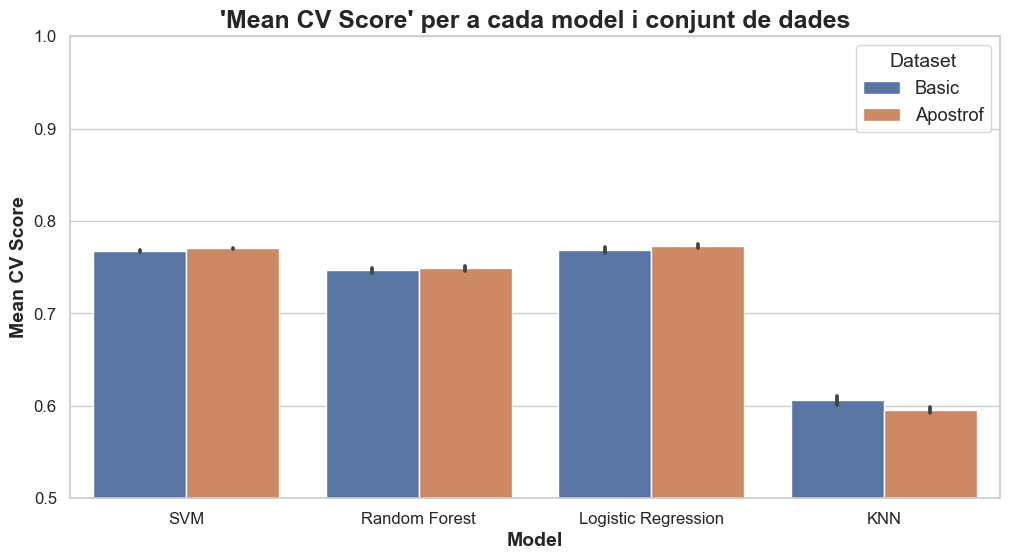

In [47]:

# 1. Gráfico de barras que muestra la puntuación media de validación cruzada para cada modelo y conjunto de datos.
plt.figure(figsize=(12, 6))
ax1 = sns.barplot(data=resultados, x='Model', y='Mean CV Score', hue='Dataset')
plt.title("'Mean CV Score' per a cada model i conjunt de dades", fontsize=18, fontweight='bold')
plt.ylim(0.5, 1)
plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.ylabel('Mean CV Score', fontsize=14, fontweight='bold')
plt.legend(title="Dataset", title_fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
plt.show()



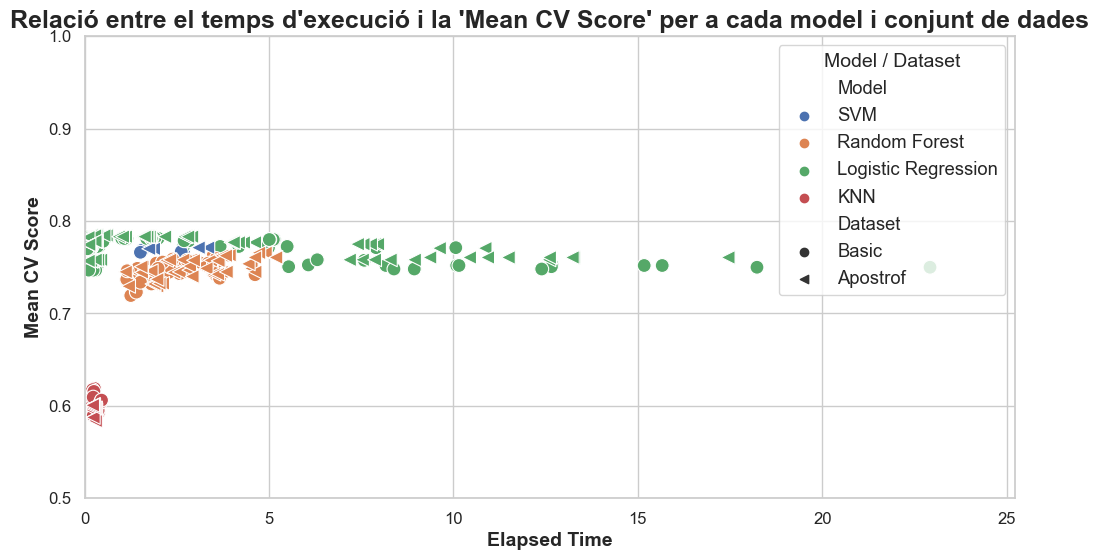

In [48]:
# 2. Gráfico de dispersión que muestra la relación entre el tiempo de ejecución y la puntuación media de validación cruzada para cada modelo y conjunto de datos.
plt.figure(figsize=(12, 6))
ax2 = sns.scatterplot(data=resultados, x='Elapsed Time', y='Mean CV Score', hue='Model', style='Dataset', s=100, markers=['o', '<'])
plt.title("Relació entre el temps d'execució i la 'Mean CV Score' per a cada model i conjunt de dades", fontsize=18, fontweight='bold')
plt.xlim(0, max(resultados['Elapsed Time']) * 1.1)
plt.ylim(0.5, 1)
plt.xlabel('Elapsed Time', fontsize=14, fontweight='bold')
plt.ylabel('Mean CV Score', fontsize=14, fontweight='bold')
plt.legend(title="Model / Dataset", title_fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
plt.show()


## Anàlisi del model seleccionat

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel


In [50]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
def testejar(train,test,model):
    inici = timeit.default_timer()
    #crear el model de random forest
    X_train = train.drop('polaritat',axis=1)
    y_train = train['polaritat']
    model.fit(X_train, y_train)
    X_test = test.drop('polaritat',axis=1)
    y_test = test['polaritat']
    y_pred = model.predict(X_test)
    matriu_conf = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    # Evaluar el rendimiento del modelo
    print("Confusion Matrix:\n", matriu_conf)
    print("Classification Report:\n", report)
    print("Accuracy Score: ", accuracy)
    return matriu_conf

In [51]:
matriu_confusioA = testejar(train_des2,test_b0,LogisticRegression(C=0.01,max_iter=600,solver='newton-cg'))

Confusion Matrix:
 [[159  41]
 [ 53 147]]
Classification Report:
               precision    recall  f1-score   support

         neg       0.75      0.80      0.77       200
         pos       0.78      0.73      0.76       200

    accuracy                           0.77       400
   macro avg       0.77      0.77      0.76       400
weighted avg       0.77      0.77      0.76       400

Accuracy Score:  0.765


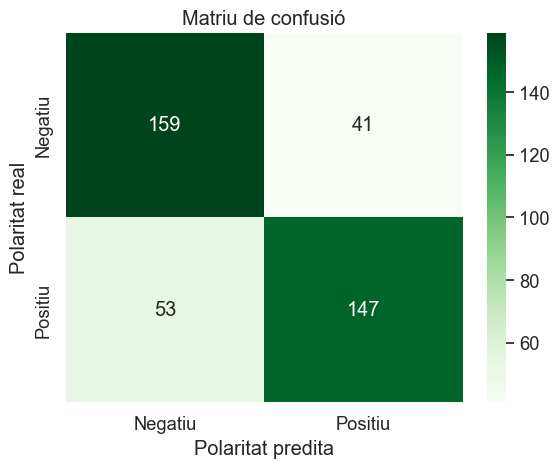

In [52]:
# Crear la matriu de confusió
cm = np.array(matriu_confusioA)

# Crear el mapa de calor
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=['Negatiu', 'Positiu'], yticklabels=[
            'Negatiu', 'Positiu'])
plt.xlabel("Polaritat predita")
plt.ylabel("Polaritat real")
plt.title("Matriu de confusió")
plt.show()

# Part B

## Preprocesing

### Obtenció de dades especifiques
Els documents utilitzats seran els mateixos que el test de la part A:

Les dades seran les mateixes del model supervisat, però apliquem un nou preprocessat.

#### Paraules

In [53]:
dades = test_neg + test_pos

#### Frases

In [54]:
# Necessitem les frases per tenir el context per obtenir els synsets
def obtenir_frases(ids):
    lst = []
    for i in ids:
        lst.append(mr.sents(i))
    return(lst)

In [55]:
frases = obtenir_frases(test_neg_id)+obtenir_frases(test_pos_id)

### Caràcters

#### Basic

In [56]:
import re

In [57]:
def nomes_nbsp(text):
    lst = []
    for i in range(len(text)):
        lst.append([])
        for j in range(len(text[i])):
            x = re.sub(r'\bnbsp', '', text[i][j]) 
            if x != '':
                lst[i].append(x)
    return lst

#### Analisis de l'apòstrof.

In [58]:
import nltk
nltk.download('averraged_perceptron_tagger')

[nltk_data] Error loading averraged_perceptron_tagger: Package
[nltk_data]     'averraged_perceptron_tagger' not found in index


False

In [59]:
word = ["It", "is", "like", "you've", "witnessed", "movie", "magic", "."]
nltk.pos_tag(word)

[('It', 'PRP'),
 ('is', 'VBZ'),
 ('like', 'IN'),
 ("you've", 'NNS'),
 ('witnessed', 'VBN'),
 ('movie', 'NN'),
 ('magic', 'NN'),
 ('.', '.')]

Este caso trata la contracción "you've" como un solo token. El POS-tagger no puede identificar correctamente el pronombre y el auxiliar separados y, en su lugar, lo etiqueta como un sustantivo plural (NNS), lo cual es incorrecto.

In [60]:
word2 = ["It", "is", "like", "you", "'", "ve", "witnessed", "movie", "magic", "."]
nltk.pos_tag(word2)

[('It', 'PRP'),
 ('is', 'VBZ'),
 ('like', 'IN'),
 ('you', 'PRP'),
 ("'", "''"),
 ('ve', 'NNS'),
 ('witnessed', 'VBD'),
 ('movie', 'NN'),
 ('magic', 'NN'),
 ('.', '.')]

En este caso, el apóstrofe se separa como un token individual. Aunque el POS-tagger reconoce correctamente "you" como un pronombre (PRP) y "ve" como un sustantivo plural (NNS), la puntuación intermedia ("'") recibe una etiqueta incorrecta como comillas simples (``). Esto hace que la estructura de la frase sea menos clara y menos útil para el análisis posterior.

In [61]:
word3 = ["It", "is", "like", "you'", "ve", "witnessed", "movie", "magic", "."]
nltk.pos_tag(word3)


[('It', 'PRP'),
 ('is', 'VBZ'),
 ('like', 'IN'),
 ("you'", 'NN'),
 ('ve', 'NN'),
 ('witnessed', 'VBD'),
 ('movie', 'NN'),
 ('magic', 'NN'),
 ('.', '.')]

Aquí, se coloca el apóstrofe junto a "you". El POS-tagger etiqueta incorrectamente "you'" como un sustantivo (NN) y "ve" también como un sustantivo (NN). Esto resulta en una estructura gramatical incorrecta y poco útil para el análisis posterior.

In [62]:
word4 = ["It", "is", "like", "you","'ve", "witnessed", "movie", "magic", "."]
nltk.pos_tag(word4)

[('It', 'PRP'),
 ('is', 'VBZ'),
 ('like', 'IN'),
 ('you', 'PRP'),
 ("'ve", 'VBP'),
 ('witnessed', 'VBN'),
 ('movie', 'NN'),
 ('magic', 'NN'),
 ('.', '.')]

Este caso separa correctamente el pronombre "you" y la contracción "'ve". El POS-tagger identifica "you" como un pronombre personal (PRP) y "'ve" como una forma auxiliar del verbo "have" (VBP). La asignación de etiquetas POS es correcta y refleja adecuadamente la estructura gramatical de la frase. Al separar las contracciones en dos tokens, se facilita el análisis de la estructura de la oración y la comprensión de su significado. 

In [63]:
word5 = ["It", "is", "like", "you","ve", "witnessed", "movie", "magic", "."]
nltk.pos_tag(word5)

[('It', 'PRP'),
 ('is', 'VBZ'),
 ('like', 'IN'),
 ('you', 'PRP'),
 ('ve', 'VBP'),
 ('witnessed', 'JJ'),
 ('movie', 'NN'),
 ('magic', 'NN'),
 ('.', '.')]

En este caso, se elimina el apóstrofe por completo y se combinan "you" y "ve" en un solo token. El POS-tagger etiqueta "you" como un pronombre personal (PRP) y "ve" como una forma auxiliar del verbo "have" (VBP), pero la contracción se pierde en este proceso. La eliminación del apóstrofe puede dificultar la identificación de las contracciones y disminuir la precisión del análisis gramatical.

Mejora, Caso 4. En este caso, separas el pronombre "you" y la contracción "'ve" (de "have") en dos tokens diferentes. Esto permite que el POS-tagger de NLTK identifique correctamente el pronombre y la contracción como dos entidades separadas y les asigne las etiquetas POS correctas.

Tengo las palabras como en el caso 2 ([["It", "is", "like", "you", "'", "ve", "witnessed", "movie", "magic", "."],[...]])y las  quero pasar a al caso 4 ([["It", "is", "like", "you","'ve", "witnessed", "movie", "magic", "."],[...]]). Genera el el codigo para hacer-lo.

Ejemploo:
def grup_apostrofs(words):
    new_words = []
    for w in words:
        new_w = []
        j = 0
        while j < len(w):
            if w[j] == "'":
                if j == 0:
                    new_w.append(w[j] + w[j+1])
                    j += 2
                elif j == len(w)-1:
                    new_w[-1] += w[j]
                    j += 1
                else:
                    new_w[-1] += w[j] + w[j+1]
                    j += 2
            else:
                new_w.append(w[j])
                j += 1
        new_words.append(new_w)
    return new_words


In [64]:
def grup_apostrofs(words):
    new_words = []
    for w in words:
        new_w = []
        j = 0
        while j < len(w):
            if w[j] == "'":
                if j == 0:
                    j += 1
                elif j == len(w)-1:
                    j += 1
                else:
                    new_w.append(w[j] + w[j+1])
                    j += 2
            else:
                new_w.append(w[j])
                j += 1
        new_words.append(new_w)
    return new_words


In [65]:
dades_a = grup_apostrofs(nomes_nbsp(dades))
frases_a = [grup_apostrofs(nomes_nbsp(doc)) for doc in frases]

In [66]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\llumf\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Synsets

### Categoria gramatical

In [67]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk. download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\llumf\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\llumf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\llumf\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [68]:
def categories(dades):
    lst = []
    for doc in dades:
        clas1 = nltk.pos_tag(doc)
        lst.append(clas1)
    return lst

In [69]:
dad_a_cat = categories(dades_a)

### Diccionaris i filtre de categories

In [70]:
def create_adjective_dict():
    d = {
        'JJ': 'a',
        'JJR': 'a',
        'JJS': 'a'
    }
    return d

In [71]:
def create_adverb_dict():
    d = {
        'RB': 'r',
        'RBR': 'r',
        'RBS': 'r',
        'WRB': 'r'
    }
    return d

In [72]:
def create_verb_dict():
    d = {
        'VB': 'v',
        'VBD': 'v',
        'VBG': 'v',
        'VBN': 'v',
        'VBP': 'v',
        'VBZ': 'v',
        'MD': 'v'
    }
    return d

In [73]:
def create_nom_dict():
    n = {
        'NN': 'n',
        'NNS': 'n',
        'NNP': 'n',
        'NNPS': 'n'
    }
    return n

In [74]:
adjective_dict = create_adjective_dict()

adjective_adverb_dict=create_nom_dict()
adjective_adverb_dict.update(create_adjective_dict())
adjective_adverb_dict.update(create_adverb_dict())

adjective_adverb_verb_dict=create_nom_dict()
adjective_adverb_verb_dict.update(create_adjective_dict())
adjective_adverb_verb_dict.update(create_adverb_dict())
adjective_adverb_verb_dict.update(create_verb_dict())

In [75]:
def traducir_lista_de_tuplas(lista_de_listas, diccionario):
    lista_traducida = []

    for sublista in lista_de_listas:
        sublista_traducida = []

        for tupla in sublista:
            palabra, etiqueta = tupla
            if etiqueta in diccionario:
                traduccion = diccionario[etiqueta]
                tupla_traducida = (palabra, traduccion)
                sublista_traducida.append(tupla_traducida)
            else:
                sublista_traducida.append(tupla)
        lista_traducida.append(sublista_traducida)

    return lista_traducida

In [76]:
tuples_a = traducir_lista_de_tuplas(dad_a_cat,adjective_dict)
tuples_a_r_n = traducir_lista_de_tuplas(dad_a_cat,adjective_adverb_dict)
tuples_a_r_n_v = traducir_lista_de_tuplas(dad_a_cat,adjective_adverb_verb_dict)

### Obtenció synsets

In [77]:
def treure_sinsets(dades,frases): # dades és un conjunt de documents representats per llistes d'strings
    dad_sinsets =[]
    for i in range(len(dades)):
        doc = dades[i]
        doc_fr = frases[i]
        lens = []
        for f in range(len(doc_fr)):
            llarg = len(doc_fr[f])
            if not f == 0:
                llarg += lens[f-1]
            lens.append(llarg)
        z = 0
        j = 0
        sinsets = []
        while j < len(doc):
            while j < lens[z]:
                context = [paraula[0] for paraula in doc_fr[z]]
                # si ses frases tenim nomes paraules i no tuples, que es probable:
                # context = doc_fr[z]
                if doc[j][1].islower():
                    sins = nltk.wsd.lesk(context,doc[j][0],doc[j][1])
                    sinsets.append(sins)
                j+=1
            z += 1
        dad_sinsets.append(sinsets)
    return dad_sinsets

In [78]:
sinsets_a = treure_sinsets(tuples_a,frases_a)
sinsets_a_r_n = treure_sinsets(tuples_a_r_n,frases_a)
sinsets_a_r_n_v = treure_sinsets(tuples_a_r_n_v,frases_a)

In [79]:
tuples_a


[[('except', 'IN'),
  ('for', 'IN'),
  ('a', 'DT'),
  ('few', 'a'),
  ('bright', 'a'),
  ('moments', 'NNS'),
  ('of', 'IN'),
  ('good', 'a'),
  ('verbal', 'a'),
  ('comedy', 'NN'),
  (',', ','),
  ('that', 'WDT'),
  ('old', 'a'),
  ('feeling', 'NN'),
  ('is', 'VBZ'),
  ('embarrassing', 'VBG'),
  ('to', 'TO'),
  ('sit', 'VB'),
  ('through', 'IN'),
  ('.', '.'),
  ('bette', 'NN'),
  ('midler', 'NN'),
  ('and', 'CC'),
  ('dennis', 'NN'),
  ('farina', 'VBP'),
  ('play', 'NN'),
  ('lilly', 'RB'),
  ('and', 'CC'),
  ('dan', 'VB'),
  (',', ','),
  ('actress', 'NN'),
  ('and', 'CC'),
  ('author', 'NN'),
  (',', ','),
  ('once', 'RB'),
  ('married', 'VBN'),
  (',', ','),
  ('now', 'RB'),
  ('violently', 'RB'),
  ('divorced', 'VBN'),
  (',', ','),
  ('and', 'CC'),
  ('back', 'RB'),
  ('together', 'RB'),
  ('one', 'CD'),
  ('last', 'a'),
  ('time', 'NN'),
  ('for', 'IN'),
  ('their', 'PRP$'),
  ('daughter', 'NN'),
  ('molly', 'RB'),
  ("'s", 'POS'),
  ('(', '('),
  ('paula', 'VB'),
  ('marshall',

In [80]:
print(len(sinsets_a[1]),len(sinsets_a_r_n[1]),len(sinsets_a_r_n_v[1]),sep='\n')

156
777
1164


Aquí comprovarem quants nones tenim

In [81]:
nones = []
for doc in sinsets_a_r_n_v:
    non = 0
    bien = 0
    for sins in doc:
        if sins is None:
            non +=1
        else:
            bien += 1
    nones.append(non/bien)
print(nones)

[0.4011299435028249, 0.3394706559263521, 0.29431438127090304, 0.31868131868131866, 0.18652849740932642, 0.20689655172413793, 0.22910216718266255, 0.46, 0.3475409836065574, 0.2, 0.25316455696202533, 0.4460431654676259, 0.4216417910447761, 0.3111111111111111, 0.29931972789115646, 0.27696793002915454, 0.2709832134292566, 0.21016949152542372, 0.28263795423956933, 0.38524590163934425, 0.4098360655737705, 0.34057971014492755, 0.22380952380952382, 0.21176470588235294, 0.28, 0.24190064794816415, 0.2514450867052023, 0.29957805907172996, 0.2742616033755274, 0.3432343234323432, 0.1593625498007968, 0.1758957654723127, 0.24315068493150685, 0.3401360544217687, 0.25, 0.21791044776119403, 0.30268199233716475, 0.2600732600732601, 0.327710843373494, 0.2727272727272727, 0.3253968253968254, 0.36637931034482757, 0.2932551319648094, 0.22662889518413598, 0.215, 0.23986486486486486, 0.21144278606965175, 0.33513513513513515, 0.23529411764705882, 0.27680311890838205, 0.25572519083969464, 0.3359580052493438, 0.2

## Models

In [82]:
import nltk
nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\llumf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\llumf\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\llumf\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Creació

In [83]:
def graus(syn):
    synset = wn.synset(syn.name())
    # getting the sentiwordnet synset
    sentiSynset = swn.senti_synset(synset.name())
    grau = (sentiSynset.pos_score(), sentiSynset.neg_score(), sentiSynset.obj_score())
    return grau

In [86]:
def model_1(document):
    positiu=0
    negatiu=0
    for syn in document:
        if syn is None:
            pass
        else:
            positividad,negatividad,objetividad = graus(syn)
            if objetividad<0.75:
                negatiu+=negatividad
                positiu+=positividad

    if positiu>negatiu:
        #print("Es positiu")
        return 1
    
    elif positiu<negatiu:
        #print("Es negatiu")
        return 0

    else:
        return 1


In [88]:
def model_2(document):
    positiu=0
    negatiu=0

    for syn in document:
        if syn is None:
            pass
        else:
            positividad,negatividad,objetividad = graus(syn)
            if positividad<negatividad:
                negatiu+=negatividad
            elif positividad>negatividad:
                positiu+=positividad

    if positiu>negatiu:
        #print("Es positiu")
        return 1
    elif positiu<negatiu:
        #print("Es negatiu")
        return 0
    else:
        #print("m'agraden les tetas")
        return 1

In [90]:
def model_3(document):
    positiu = 0
    negatiu = 0

    for syn in document:
        if syn is not None:
            positividad,negatividad,objetividad = graus(syn)
            subjetividad = 1 - objetividad

            if positividad < negatividad:
                negatiu += (negatividad - positividad) * subjetividad
            elif positividad > negatividad:
                positiu += (positividad - negatividad) * subjetividad

    if positiu > negatiu:
        return 1
    elif positiu < negatiu:
        return 0
    else:
        return 1

In [92]:
def model_4(document): #document que és una llista de sinsets
    positiu = 0
    negatiu = 0
    total_subjetividad = 0

    for syn in document:
        if syn is not None:
            positividad, negatividad, objetividad = graus(syn)
            subjetividad = 1 - objetividad
            total_subjetividad += subjetividad

            positiu += positividad * subjetividad
            negatiu += negatividad * subjetividad

    if total_subjetividad == 0:
        return 1  # Si no hay subjetividad en el texto, devuelve 1 por defecto

    positiu /= total_subjetividad
    negatiu /= total_subjetividad

    if positiu > negatiu:
        return 1
    else:
        return 0


In [85]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
import timeit
def entrenar_validar(model,dades):
    inici = timeit.default_timer()
    resultats = []
    etiquetes = 200*[0] + 200* [1]
    for doc in dades:
        resultats.append(model(doc))
    matriu_conf = confusion_matrix(etiquetes, resultats)
    report = classification_report(etiquetes, resultats)
    accuracy = accuracy_score(etiquetes, resultats)
    final = timeit.default_timer()
    temps = final - inici
    # Evaluar el rendimiento del modelo
    print("Confusion Matrix:\n", matriu_conf)
    print("Classification Report:\n", report)
    print("Accuracy Score: ", accuracy)
    print("Temps d'execució:", temps)
    return accuracy,temps,matriu_conf

### Tria model

In [94]:
models = [model_1, model_2, model_3, model_4]
dad = [sinsets_a,sinsets_a_r_n,sinsets_a_r_n_v]
cat = ['adjectius','adj + adv + nom','adj + adv + nom + verb']
matrius = []
resultats = []
for model in models:
    for i in range(len(dad)):
        acc, temp,matr = entrenar_validar(model,dad[i])
        resultats.append([model.__name__,cat[i],acc,temp])
        matrius.append(matr)

Confusion Matrix:
 [[121  79]
 [ 73 127]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.60      0.61       200
           1       0.62      0.64      0.63       200

    accuracy                           0.62       400
   macro avg       0.62      0.62      0.62       400
weighted avg       0.62      0.62      0.62       400

Accuracy Score:  0.62
Temps d'execució: 0.2180587000000287
Confusion Matrix:
 [[142  58]
 [ 98 102]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.71      0.65       200
           1       0.64      0.51      0.57       200

    accuracy                           0.61       400
   macro avg       0.61      0.61      0.61       400
weighted avg       0.61      0.61      0.61       400

Accuracy Score:  0.61
Temps d'execució: 2.391592699999933
Confusion Matrix:
 [[129  71]
 [ 92 108]]
Classification Report:
               precision    reca

In [96]:
import pandas as pd
df = pd.DataFrame(resultats)
df.columns = ["Model","Categories","Accuracy","Temps d'execució"]
df

Model              Categories  Accuracy  Temps d'execució
0   model_1               adjectius    0.6200          0.218059
1   model_1         adj + adv + nom    0.6100          2.391593
2   model_1  adj + adv + nom + verb    0.5925          2.487356
3   model_2               adjectius    0.6075          0.474798
4   model_2         adj + adv + nom    0.6025          2.187419
5   model_2  adj + adv + nom + verb    0.6025          2.899891
6   model_3               adjectius    0.6225          0.289425
7   model_3         adj + adv + nom    0.6175          1.500800
8   model_3  adj + adv + nom + verb    0.6250          1.976858
9   model_4               adjectius    0.6250          0.185227
10  model_4         adj + adv + nom    0.6175          1.455195
11  model_4  adj + adv + nom + verb    0.6250          2.373888

In [97]:
x = df[df['Accuracy']>= df['Accuracy'].quantile(0.7)]
x


Model              Categories  Accuracy  Temps d'execució
6   model_3               adjectius    0.6225          0.289425
8   model_3  adj + adv + nom + verb    0.6250          1.976858
9   model_4               adjectius    0.6250          0.185227
11  model_4  adj + adv + nom + verb    0.6250          2.373888

In [98]:
millor = x[x["Temps d'execució"] == x["Temps d'execució"].min()]
index_millor = millor.index[0]
millor

Model Categories  Accuracy  Temps d'execució
9  model_4  adjectius     0.625          0.185227

In [99]:
matriu_confusioB = matrius[index_millor]
matriu_confusioB

array([[114,  86],
       [ 64, 136]], dtype=int64)

#### Plots

In [100]:
import matplotlib.pyplot as plt

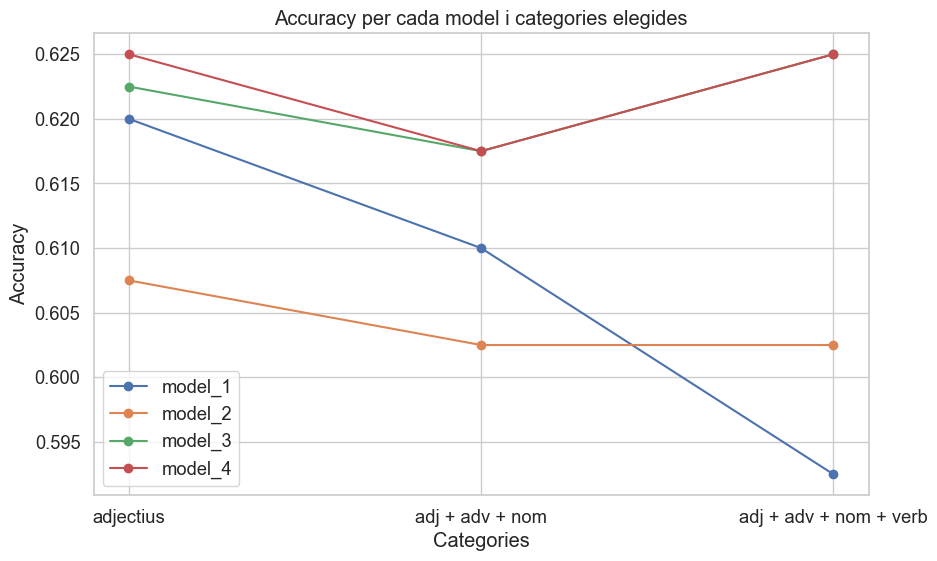

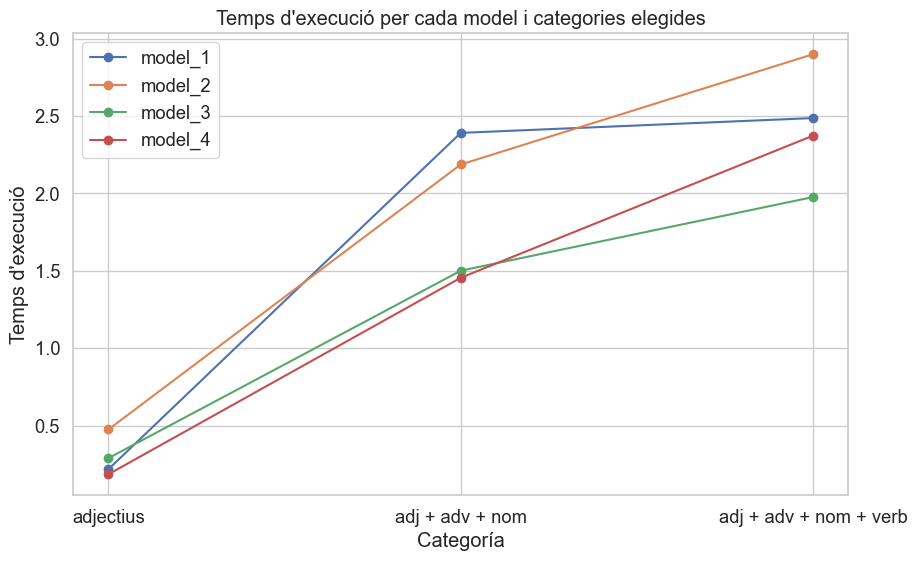

In [101]:
fig, ax = plt.subplots(figsize=(10,6))
for i, model in enumerate(df['Model'].unique()):
    df_model = df[df['Model']==model]
    ax.plot(df_model['Categories'], df_model['Accuracy'], 
            label=model, color=f'C{i}', marker='o')
ax.set_title('Accuracy per cada model i categories elegides')
ax.set_xlabel('Categories')
ax.set_ylabel('Accuracy')
ax.legend()

# crear el gráfico de tiempo de ejecución
fig, ax = plt.subplots(figsize=(10,6))
for i, model in enumerate(df['Model'].unique()):
    df_model = df[df['Model']==model]
    ax.plot(df_model['Categories'], df_model["Temps d'execució"], 
            label=model, color=f'C{i}', marker='o')
ax.set_title("Temps d'execució per cada model i categories elegides")
ax.set_xlabel('Categoría')
ax.set_ylabel("Temps d'execució")
ax.legend()

plt.show()

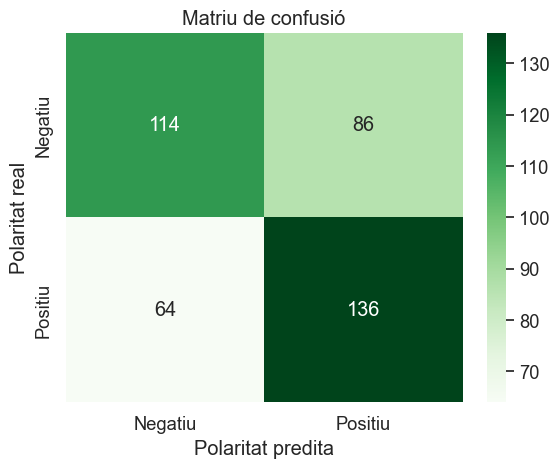

In [102]:
# Crear la matriu de confusió
cm = np.array(matriu_confusioB)

# Crear el mapa de calor
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=['Negatiu', 'Positiu'], yticklabels=[
            'Negatiu', 'Positiu'])
plt.xlabel("Polaritat predita")
plt.ylabel("Polaritat real")
plt.title("Matriu de confusió")
plt.show()

# Comparació

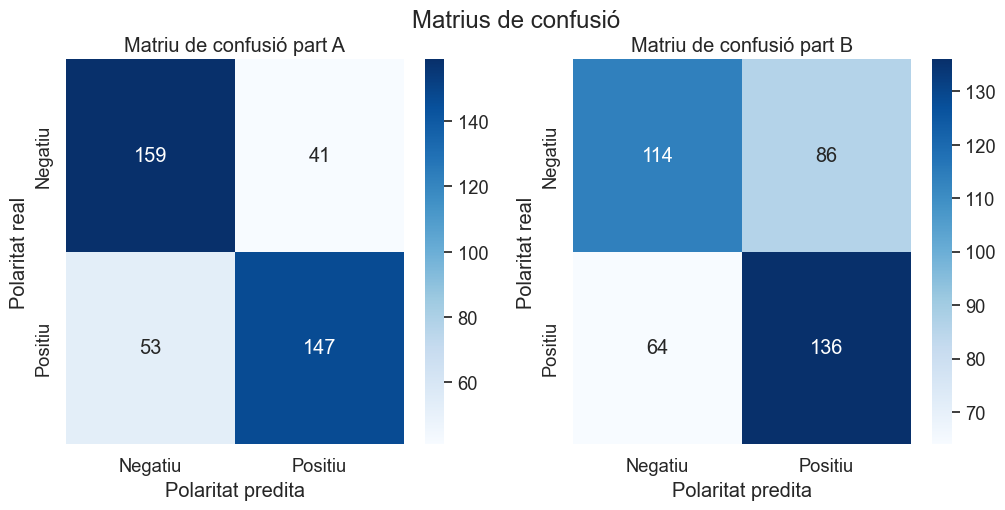

In [152]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Crear les matrius de confusió
cm1 = np.array(matriu_confusioA)
cm2 = np.array(matriu_confusioB)

# Configurar el gràfic amb subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Matrius de confusió")

# Crear el primer mapa de calor
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=['Negatiu', 'Positiu'], yticklabels=['Negatiu', 'Positiu'], ax=axs[0])
axs[0].set_xlabel("Polaritat predita")
axs[0].set_ylabel("Polaritat real")
axs[0].set_title("Matriu de confusió part A")

# Crear el segon mapa de calor
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", xticklabels=['Negatiu', 'Positiu'], yticklabels=['Negatiu', 'Positiu'], ax=axs[1])
axs[1].set_xlabel("Polaritat predita")
axs[1].set_ylabel("Polaritat real")
axs[1].set_title("Matriu de confusió part B")

# Mostrar el gràfic
plt.show()


In [151]:
print(cm1)
print(cm2)

[[159  41]
 [ 53 147]]
[[114  86]
 [ 64 136]]


## Prova el teu propi text

In [104]:
def part2(text):
    dades = [nltk.word_tokenize(text)]
    frases = [[]]
    for i in nltk.sent_tokenize(text):
        frases[0].append(nltk.word_tokenize(i))
    a = treure_sinsets(traducir_lista_de_tuplas((categories(dades)),adjective_dict),frases)
    return model_4(a[0])

In [120]:
def predir(train,test,model):
    X_train = train.drop('polaritat',axis=1)
    y_train = train['polaritat']
    #y_train = y_train.replace({'neg': 0, 'pos': 1})
    model.fit(X_train, y_train)
    X_test = test.drop('polaritat',axis=1)
    y_pred = model.predict(X_test)
    return y_pred

In [127]:
def identify(model,text):
    dades = [nltk.word_tokenize(text)]
    if model == 'Supervisat':
        dades_pre = prepro1(dades)
        train_a0,test_a0,cols0 = treure_dataframes(train_neg_a,train_pos_a,dades_pre,[],'english')
        resultat = predir(train_a0,test_a0,LogisticRegression(C=0.01,max_iter=600,solver='newton-cg'))
        if resultat[0] == 'neg':
            #print('El text té polaritat negativa')
            pass
        else:
            #print('El text té polaritat positiva')
            pass
        return resultat[0]
    
    elif model == 'No supervisat':
        result = part2(text)
        if result == 1:
            #print('El text té polaritat positiva')
            resultat = 'pos'
        else:
            #print('El text té polaritat negativa')
            resultat = 'neg'
        return resultat

In [147]:
identify("No supervisat", "amazingly good, i really liked it amaz")

'pos'

In [ ]:
nltk.sent_tokenize("hola que tal estas")

In [111]:
#Llibreries necessàries
import ipywidgets as widgets
from ipywidgets import interact, HBox, VBox
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import warnings
from sklearn.exceptions import ConvergenceWarning

In [143]:
dropdown = widgets.Dropdown(
    options=["Supervisat", "No supervisat"],
    value='Supervisat',
    description='Model:',
    disabled=False,
)


textarea = widgets.Textarea(
    value='The movie lacks emotional depth and bland action, leaving the viewer disconnected and bored.',
    placeholder='Type something',
    description="Opinion:",
    layout=widgets.Layout(width='80%', height='100x'),  # Ajusta el tamaño aquí
    disabled=False,   

)

container = widgets.VBox([dropdown, textarea])

def on_button_click(b):
    with output:
        identificar(dropdown.value, textarea.value)

def identificar(model, text):
    clear_output(wait=True)
    print('  Obtenit resultats...\n')
    resultat = identify(model, text)
    if resultat == 'neg':
        print("  El text té polaritat negativa")
    else:
        print("  El text té polaritat positiva")

output = widgets.Output()
button = widgets.Button(description="Identificar")
button.on_click(on_button_click)

widgets_box = widgets.VBox([container, button, output])
display(widgets_box)



style2 = {'description_width': 'initial'}
textarea.style = style2